In [ ]:
import sys
import gc

import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_auc_score
import numpy as np
import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
!pip install datasets
from datasets import Dataset
from tqdm.auto import tqdm
from transformers import PreTrainedTokenizerFast


import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

import pickle

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00


## Hyperparameters

In [ ]:
LOWERCASE = False
VOCAB_SIZE = 8000
MAX_LENGTH = 128
BATCH_SIZE = 64

LEARNING_RATE = 2.00E-04
NUM_EPOCHS = 8
DROPOUT = 0
ACTIVATION = "relu"

D_MODEL = 512 # embedding
N_HEAD = 4
N_LAYERS = 3

# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=BETAS, eps=EPS, weight_decay=WEIGHT_DECAY)
BETAS = (0.85, 0.999)
EPS = 1e-08
WEIGHT_DECAY = 0.05

## Load and process data

In [ ]:
data = pd.read_csv("/content/train_v2_drcat_02.csv", sep=',')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.3, shuffle=True, random_state=0)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
print(len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), len(y_test))

31407 6730 6731 31407 6730 6731


In [ ]:
# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
# Adding normalization and pre_tokenizer
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)
# Creating huggingface dataset object
dataset = X_train
def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i : i + 1000]
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tokenized_texts_train = []

for text in tqdm(X_train.tolist()):
    tokenized_texts_train.append(tokenizer.tokenize(text))

  0%|          | 0/31407 [00:00<?, ?it/s]

In [ ]:
print(tokenizer.pad_token_id)

# Get list of all tokens in the tokenizer
all_tokens = list(tokenizer.vocab.keys())

print(len(all_tokens))

1
8000


In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, tokenizer, max_length):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]

        # Encode the text, ensuring it's padded to the max_length
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            pad_to_max_length = True,
            return_attention_mask = True,
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].clone().detach().flatten()
        attention_mask = encoding['attention_mask'].squeeze(0)

        attention_mask = attention_mask.to(dtype=torch.bool)
        attention_mask = ~attention_mask


        target = torch.FloatTensor([target])

        return input_ids, target, attention_mask


## Sinusoidal Positional Embedding Model

In [ ]:
from typing import Optional

class SinusoidalPositionalEmbedding(nn.Embedding):
    """This module produces sinusoidal positional embeddings of any length."""
    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None) -> None:
        super().__init__(num_positions, embedding_dim)
        self.weight = self._init_weight(self.weight)

    @staticmethod
    def _init_weight(out: nn.Parameter) -> nn.Parameter:
        """
        Interleaved sine and cosine position embeddings
        """
        out.requires_grad = False
        out.detach_()

        N, D = out.shape

        ## TODO: Create a N x D//2 array of position encodings (argument to the sine/cosine)
        inds = np.arange(0, D // 2)
        k = np.arange(N)
        denom = 1 / np.power(10_000, 2*inds / D)
        position_enc = np.outer(k, denom)  # Efficiently make N x D//2 array for all positions/dimensions
        #####

        out[:, 0::2] = torch.FloatTensor(np.sin(position_enc))  # Even indices get sin
        out[:, 1::2] = torch.FloatTensor(np.cos(position_enc))  # Odd indices get cos
        return out

    @torch.no_grad()
    def forward(self, input_ids_shape: torch.Size, past_key_values_length: int = 0) -> torch.Tensor:
        """`input_ids_shape` is expected to be [bsz x seqlen]."""
        bsz, seq_len = input_ids_shape[:2]
        positions = torch.arange(
            past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
        )
        return super().forward(positions)

In [ ]:
class DAI_Transformer(nn.Module):
    def __init__(self, d_model=D_MODEL, n_head=N_HEAD, n_layers=N_LAYERS):
        super().__init__()
        self.d_model = d_model
        self.n_head = n_head
        self.n_layers = n_layers

        # Input embedding layers
        self.input_embeddings = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=d_model, padding_idx=0)#tokenizer.pad_token_id) # 30522 is vocab size, d_model is embedding space size

        self.position_encoding = SinusoidalPositionalEmbedding(MAX_LENGTH, embedding_dim=d_model) # 1200 is max length (num_positions)

        self.input_layer_norm = nn.LayerNorm(d_model)

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=self.n_head,
            dim_feedforward=2*d_model,
            dropout=DROPOUT,
            activation=ACTIVATION,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.n_layers)

        # Output layers
        self.output_norm = nn.LayerNorm(d_model)  # With pre-layer norm transformer, we should do one more before output

        self.output_layer = nn.Linear(512, 1)

    def forward(self, input_ids, padding_mask):
        embedding_vectors = self.input_embeddings(input_ids)
        position_vectors = self.position_encoding(input_ids.shape)
        inputs = embedding_vectors + position_vectors  # Add position encodings
        inputs = self.input_layer_norm(inputs)

        if padding_mask is not None:
            outputs = self.transformer_encoder(inputs, src_key_padding_mask=padding_mask)
        else:
            outputs = self.transformer_encoder(inputs)

        # SHAPE HERE IS [8, 256, 512]
        # Apply mean pooling to the output
        outputs = outputs.mean(dim=1)

        # Output layers
        outputs = self.output_norm(outputs)
        outputs = self.output_layer(outputs)
        outputs = outputs.squeeze(-1)


        return outputs

## Learned Positional Embedding Model

In [ ]:
import torch
import torch.nn as nn

class DAI_Transformer(nn.Module):
    def __init__(self, d_model=D_MODEL, n_head=N_HEAD, n_layers=N_LAYERS, max_length=MAX_LENGTH, vocab_size=VOCAB_SIZE):
        super().__init__()
        self.d_model = d_model

        # Input embedding layers
        self.input_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model, padding_idx=0)

        # Learned position embeddings
        self.position_embeddings = nn.Embedding(max_length, d_model)

        self.input_layer_norm = nn.LayerNorm(d_model)

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=2 * d_model,
            dropout=DROPOUT,
            activation=ACTIVATION,
            batch_first=True,
            norm_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Output layers
        self.output_norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, input_ids, padding_mask):
        # Token embeddings
        token_embeddings = self.input_embeddings(input_ids)

        # Position embeddings
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        position_embeddings = self.position_embeddings(position_ids)

        # Combine token and position embeddings
        inputs = token_embeddings + position_embeddings
        inputs = self.input_layer_norm(inputs)

        if padding_mask is not None:
            outputs = self.transformer_encoder(inputs, src_key_padding_mask=padding_mask)
        else:
            outputs = self.transformer_encoder(inputs)

        outputs = outputs.mean(dim=1)
        outputs = self.output_norm(outputs)
        outputs = self.output_layer(outputs)
        outputs = outputs.squeeze(-1)

        return outputs


## Train and Test

In [ ]:
def train(model, train_loader, loss_fn, optimizer, accumulation_steps, epoch=-1):
    total_loss = 0
    max_grad_norm = 1.0
    model.train()
    optimizer.zero_grad()  # Initialize gradient accumulation

    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}") as t:
        for i, batch in t:
            inputs = batch[0].to(DEVICE)
            targets = batch[1].to(DEVICE).squeeze()
            mask = batch[2].to(DEVICE)

            if torch.isnan(inputs).any() or torch.isnan(targets).any():
                print("NaNs in inputs or targets")


            outputs = model(inputs, mask)
            #print(outputs)
            loss = loss_fn(outputs, targets) / accumulation_steps
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

                optimizer.zero_grad()  # Reset gradients after updating

            total_loss += loss.item() * accumulation_steps  # Scale loss back up
            t.set_description(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {total_loss / ((i + 1) * accumulation_steps):.2f}")

    final_loss = total_loss / (len(train_loader) * accumulation_steps)
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}")
    return final_loss



In [ ]:
def test(model, test_loader, loss_fn, epoch=-1):
    total_loss = 0
    # model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, batch in enumerate(test_loader):
        with torch.no_grad():
            # Access data using keys from the dictionary
            inputs = batch[0].to(DEVICE)
            targets = batch[1].to(DEVICE).squeeze()
            mask = batch[2].to(DEVICE)

            outputs = model(inputs, mask)
            loss = loss_fn(outputs, targets)

            # track values to compute statistics
            total_loss += loss.item()

    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}")
    return final_loss

In [ ]:
def masked_loss(outputs, targets):

    loss_fn = torch.nn.BCEWithLogitsLoss()
    loss = loss_fn(outputs, targets)

    return loss

In [ ]:
accumulation_steps = 4
torch.manual_seed(0)
model = DAI_Transformer().to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=BETAS, eps=EPS, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)


loss_fn = masked_loss

train_ds = TextDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_ds = TextDataset(X_val, y_val, tokenizer, MAX_LENGTH)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    train_loss = train(model, train_loader, loss_fn, optimizer, accumulation_steps, epoch)
    test_loss= test(model, valid_loader, loss_fn, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Epoch 1:   0%|          | 0/491 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1 done. Average train loss = 0.09
Epoch 1 done. Average test loss = 0.13


Epoch 2:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 2 done. Average train loss = 0.02
Epoch 2 done. Average test loss = 0.09


Epoch 3:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 3 done. Average train loss = 0.01
Epoch 3 done. Average test loss = 0.07


Epoch 4:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 4 done. Average train loss = 0.01
Epoch 4 done. Average test loss = 0.07


Epoch 5:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 5 done. Average train loss = 0.01
Epoch 5 done. Average test loss = 0.12


Epoch 6:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 6 done. Average train loss = 0.00
Epoch 6 done. Average test loss = 0.11


Epoch 7:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 7 done. Average train loss = 0.00
Epoch 7 done. Average test loss = 0.15


Epoch 8:   0%|          | 0/491 [00:00<?, ?it/s]

Epoch 8 done. Average train loss = 0.00
Epoch 8 done. Average test loss = 0.09


In [ ]:
print(train_losses)
print(test_losses)

[0.08891675725309918, 0.023297179767495884, 0.013311864625754559, 0.007749672396002525, 0.005126917501600329, 0.003848176056661499, 0.0026411438641282888, 0.0017788457184433949]
[0.1296278090163503, 0.08908033632796328, 0.0667904915050867, 0.0697238587726013, 0.12285273558188907, 0.10713260030354162, 0.15471309739305586, 0.09134935279349897]


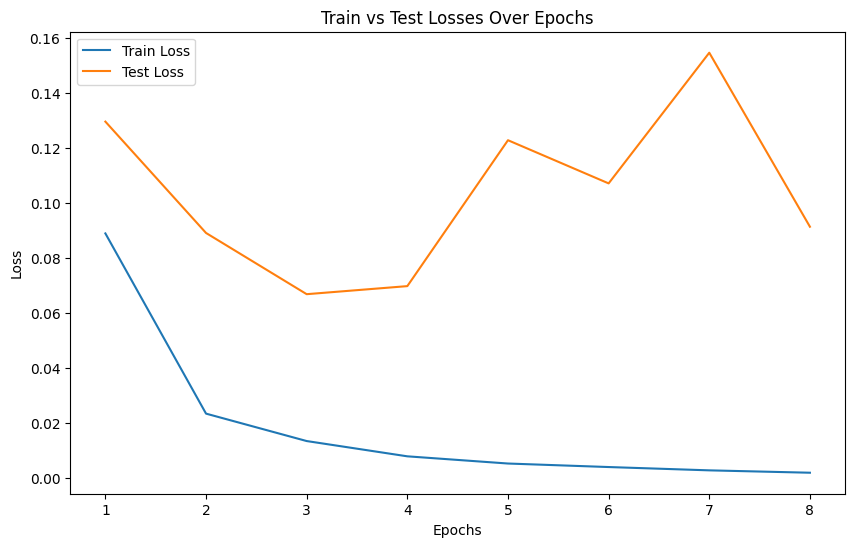

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Create a plot for train and test losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')

# Adding title and labels
plt.title('Train vs Test Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, NUM_EPOCHS + 1))

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
def test_model(model, test_loader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    final_preds = []
    final_targets = []

    with torch.no_grad():  # No need to calculate gradients
        for batch in test_loader:
            inputs = batch[0].to(DEVICE)
            mask = batch[2].to(DEVICE)
            targets = batch[1].to(DEVICE).squeeze()
            outputs = model(inputs, mask)#, mask)


            # Convert logits to probabilities using sigmoid
            preds = torch.sigmoid(outputs).cpu().numpy()
            final_preds.extend(preds.flatten())  # Flatten to ensure correct shape
            final_targets.extend(targets.cpu().numpy())
            #final_targets = batch[1].to(DEVICE).squeeze()

    # Return the predictions and actual labels
    return final_preds, final_targets

In [ ]:
# Run the test function and get predictions and labels
final_preds, final_targets = test_model(model, valid_loader, loss_fn, DEVICE)

# Convert probabilities to binary predictions
binary_preds = [1 if p > 0.5 else 0 for p in final_preds]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


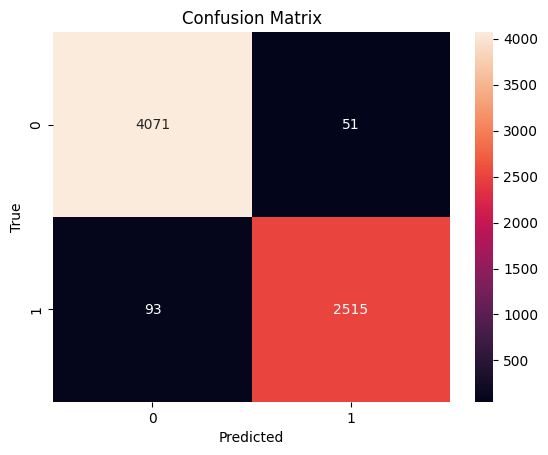

In [ ]:
# Confusion Matrix
cm = confusion_matrix(final_targets, binary_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(final_targets, binary_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.86%
